# **Stock Price Prediction Project**

In this notebook, we will build a predictive model for a stock's next-day closing price using historical data and technical indicators. The objectve is to develop and evaluate multiple models for forecasting based on past trends, patterns, and feature engineering.

- **Load** daily stock price data from an Excel file on Google Drive
- **Clean** and **preprocess** the data: handling date formats, missing values, and sort chronologically
- Perform **Exploratory Data Analysis (EDA)** with line plots, return distributions, moving averages, and correlation heatmaps
- **Engineer** advanced features:
  - Technical indicators like **RSI (14)**
  - Multiple **Moving Averages** (MA_10, MA_30, MA_50, MA_100)
  - **Lagged features** such as previous day's closing price, returns over 2 and 5 days.
- **Split data** chronologically into training and testing sets (80/20)
- **Train** and **evaluate** four regression models (Linear Regression, Decision Tree, Random Forest, XGBoost Regressor)  
- **Evaluate** each model using R² and RMSE  
- **Apply Time Series Cross-Validation (TSCV)** to assess generalization over multiple temporal splits
- **Compare and visualise** model results using performance tables and heatmaps
- **Conclude** with key insights, best-performing model, and suggestions for improvement


## **Phase 1: Setup & Data Loading**

In this phase, we will:

1. Mount Google Drive and import necessary libraries  
2. Load historical stock price data from an Excel file (2018–2022)  
3. Convert the 'Date' column to datetime format  
4. Inspect the dataset structure and preview sample records  


In [18]:
#@title Phase 1: Install & Load Data { display-mode: "code" }

#1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#2) Import required libraries
import pandas as pd

#3) Read Excel file from Google Drive
file_path='/content/drive/MyDrive/stock_price_prediction_dataset.xlsx'
raw=pd.read_excel(file_path)

#4) Ensure 'Date' column is in datetime format
raw['Date'] = pd.to_datetime(raw['Date'])

#5) Inspect the data
print("Columns in dataset:", raw.columns.tolist())
print("Data shape:", raw.shape)
display(raw.head())

#6) Copy to df for further use
df=raw.copy()

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDate range in dataset:")
print(df['Date'].min().date(), "to", df['Date'].max().date())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columns in dataset: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Data shape: (1009, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900



Missing values per column:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Date range in dataset:
2018-02-05 to 2022-02-04


## **Phase 2: Cleaning & Initial Feature Engineering**

In this phase, we will:

1. Remove any rows with missing values in key price and volume columns (OHLCV)  
2. Ensure the `Date` column is in datetime format and sort the dataset chronologically  
3. Create a numerical date feature (`Date_ordinal`) for modeling  
4. Add lagged closing prices (`Close_Lag1`) and compute daily returns (`Returns`)  


In [19]:
#@title Phase 2: Clean & Initial Lags { display-mode: "code" }

import datetime

# 1. Drop rows with missing Open, High, Low, Close, or Volume values
df = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume']).copy()

# 2. Convert 'Date' to datetime (precautionary) and sort chronologically
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# 3. Create numeric date feature for time-based modeling
df['Date_ordinal'] = df['Date'].map(datetime.datetime.toordinal)

# 4. Add lagged close (previous day) and daily return (% change)
df['Close_Lag1'] = df['Close'].shift(1)
df['Returns'] = df['Close'].pct_change()

# 5. Drop initial row(s) with NaN due to lag/returns
df = df.dropna().reset_index(drop=True)

# Final check
print("After Phase 2 shape:", df.shape)
display(df[['Date', 'Close', 'Date_ordinal', 'Close_Lag1', 'Returns']].head())


After Phase 2 shape: (1008, 10)


,Date,Close,Date_ordinal,Close_Lag1,Returns
0,2018-02-06,265.720001,736731,254.259995,0.045072
1,2018-02-07,264.559998,736732,265.720001,-0.004366
2,2018-02-08,250.100006,736733,264.559998,-0.054657
3,2018-02-09,249.470001,736734,250.100006,-0.002519
4,2018-02-12,257.950012,736737,249.470001,0.033992


## **Phase 3: Exploratory Data Analysis (3.1–3.4)**

We explore the dataset through the following visualizations:

- **3.1** Closing price trend over time  
- **3.2** Distribution and boxplot of daily returns  
- **3.3** Moving averages (20-day and 50-day) overlaid on closing price  
- **3.4** Correlation heatmap among key numerical features  


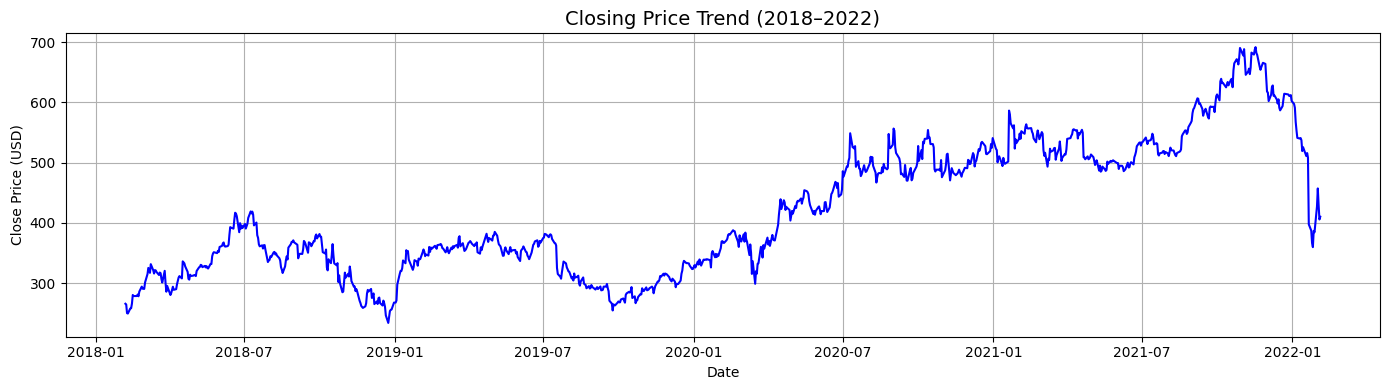

In [20]:
#@title 3.1 Closing Price Trend { display-mode: "code" }
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 4))
plt.plot(df['Date'], df['Close'], color='blue')
plt.title('Closing Price Trend (2018–2022)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()


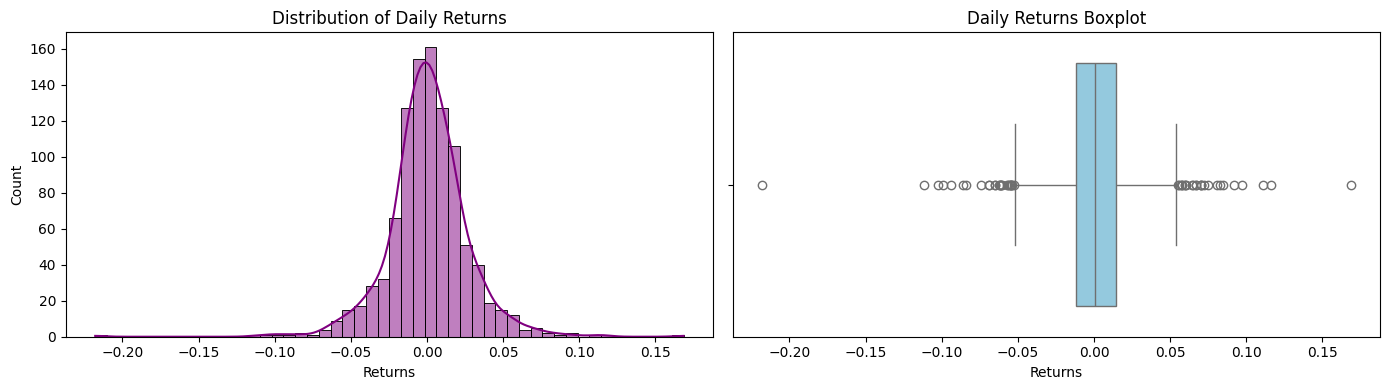

In [21]:
#@title 3.2 Daily Returns Distribution & Boxplot { display-mode: "code" }
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(df['Returns'], bins=50, kde=True, ax=ax[0], color='purple')
ax[0].set_title('Distribution of Daily Returns')
ax[0].set_xlabel('Returns')

sns.boxplot(x=df['Returns'], ax=ax[1], color='skyblue')
ax[1].set_title('Daily Returns Boxplot')

plt.tight_layout()
plt.show()


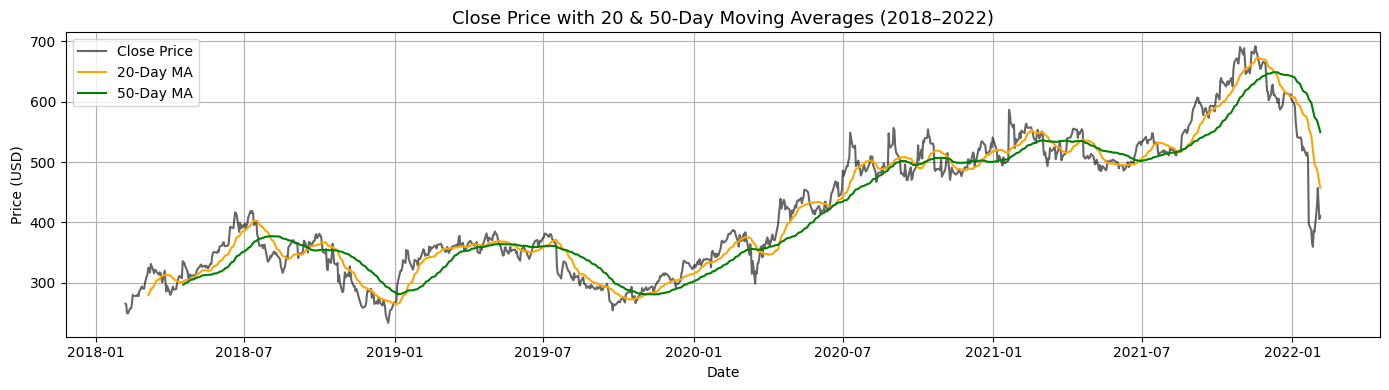

In [22]:
#@title 3.3 Moving Averages Overlay { display-mode: "code" }
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

plt.figure(figsize=(14, 4))
plt.plot(df['Date'], df['Close'], label='Close Price', color='black', alpha=0.6)
plt.plot(df['Date'], df['MA_20'], label='20-Day MA', color='orange')
plt.plot(df['Date'], df['MA_50'], label='50-Day MA', color='green')
plt.title('Close Price with 20 & 50-Day Moving Averages (2018–2022)', fontsize=13)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


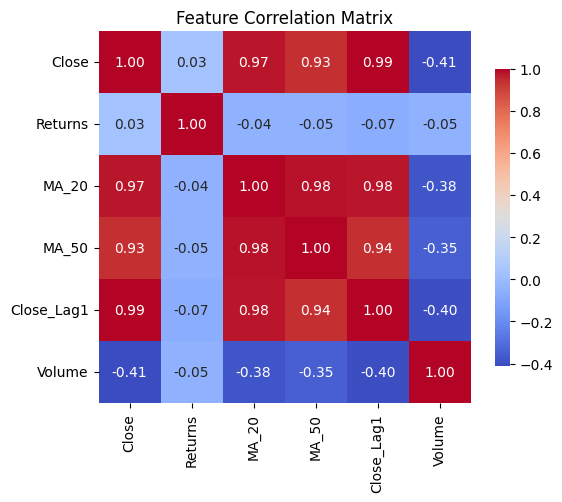

In [23]:
#@title 3.4 Correlation Heatmap { display-mode: "code" }
corr_feats = ['Close', 'Returns', 'MA_20', 'MA_50', 'Close_Lag1', 'Volume']
corr_matrix = df[corr_feats].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


## **Phase 4: Technical Indicators & Extended Lags**

We enhance our feature set by engineering useful time-series-based predictors:

- **RSI (14-day)**: Momentum oscillator that indicates overbought/oversold zones  
- **Moving Averages**: 10-day, 30-day, 50-day, and 100-day to capture short- and long-term trends  
- **Lagged Returns**: 2-day and 5-day lagged returns to help the model recognize short-term momentum  


In [24]:
#@title Phase 4: Add Indicators & Extended Lags { display-mode: "code" }

# --- 1. Compute RSI (14-day) ---
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# --- 2. Moving Averages ---
for window in [10, 30, 50, 100]:
    df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()

# --- 3. Lagged Returns ---
df['Returns_Lag2'] = df['Returns'].shift(2)
df['Returns_Lag5'] = df['Returns'].shift(5)

# --- 4. Drop rows with NaNs from rolling calculations ---
df = df.dropna().reset_index(drop=True)

# --- 5. Inspect resulting DataFrame ---
print("After Phase 4 shape:", df.shape)
display(df[['Date', 'Close', 'MA_10', 'MA_30', 'MA_50', 'MA_100', 'RSI_14', 'Returns_Lag2', 'Returns_Lag5']].head())


After Phase 4 shape: (909, 18)


,Date,Close,MA_10,MA_30,MA_50,MA_100,RSI_14,Returns_Lag2,Returns_Lag5
0,2018-06-28,395.420013,400.033008,369.612670,349.986402,323.534301,64.241931,0.038780,-0.003167
1,2018-06-29,391.429993,399.978006,371.819670,351.161002,324.791401,61.948022,-0.022534,-0.010471
2,2018-07-02,398.179993,400.756006,374.286336,352.569202,326.127601,63.228835,0.012885,-0.064730
3,2018-07-03,390.519989,399.310004,376.243002,354.005801,327.531801,54.361971,-0.010091,0.038780
4,2018-07-05,398.390015,397.473004,378.468670,355.833202,329.021001,52.372772,0.017244,-0.022534


## Phase 5: Model Preparation, Training & Evaluation

This phase involves building, training, and comparing different machine learning models on the stock price dataset. Each sub-phase is structured as follows:

- **5.1: Data Splitting**  

- **5.2: Train & Evaluate Models**  

- **5.3: Display Comparison Table**  

- **5.4: Visualize Model Comparison**  

- **5.5: Time Series Cross-Validation**  

- **5.6: Train and Evaluate XGBoost Regressor**

- **5.7: SHAP Analysis – Feature Importance**  


### **5.1 Prepare Features and Split Data**

- **Features**:  
  `Open, High, Low, Volume, MA_10, MA_30, MA_50, MA_100, RSI_14, Close_Lag1, Returns_Lag2, Returns_Lag5`  
- **Target**: next-day closing price (`Close.shift(-1)`)  
- **Split**: chronological 80% training, 20% testing  


In [25]:
#@title Phase 5.1: Feature Matrix & Train/Test Split { display-mode: "code" }
features = [
    'Open','High','Low','Volume',
    'MA_10','MA_30','MA_50','MA_100',
    'RSI_14','Close_Lag1','Returns_Lag2','Returns_Lag5'
]

X = df[features]
y = df['Close'].shift(-1)

# Drop last row (target is NaN after shift)
X = X.iloc[:-1]
y = y.iloc[:-1]

# Chronological split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test: ", X_test.shape,  "| y_test: ",  y_test.shape)


X_train: (726, 12) | y_train: (726,)
X_test:  (182, 12) | y_test:  (182,)


### **5.2 Train & Compare Models**

We will train three models and evaluate each on the test set:
- **Linear Regression**  
- **Decision Tree Regressor**  
- **Random Forest Regressor**  

Metrics:
- **R²** (higher = better)  
- **RMSE** (lower = better)  


In [42]:
#@title Phase 5.2: Train & Evaluate Models { display-mode: "code" }

import numpy as np
from sklearn.linear_model    import LinearRegression
from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_squared_error, r2_score
import pandas as pd

# Confirm train/test data
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_test  shape:", X_test.shape,  "| y_test  shape:",  y_test.shape)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree':     DecisionTreeRegressor(random_state=42),
    'Random Forest':     RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train, predict, evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({
        'Model': name,
        'R²': round(r2, 3),
        'RMSE': round(rmse, 3)
    })

# Store in results_df
results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)




X_train shape: (726, 12) | y_train shape: (726,)
X_test  shape: (182, 12) | y_test  shape: (182,)


## **Phase 5.3: Model Performance Comparison**

We now compare the three models on the test set.  
- **R²** (closer to 1 is better)  
- **RMSE** (lower is better)  

| Model             |   R²   |  RMSE  |
|-------------------|--------|--------|
| Linear Regression | 0.962  | 13.913 |
| Decision Tree     | 0.432  | 53.726 |
| Random Forest     | 0.187  | 64.290 |

In [38]:
#@title Phase 5.3: Display Comparison Table { display-mode: "code" }
from IPython.display import display, Markdown

display(Markdown("#### Model Performance Comparison"))
display(results_df)


#### Model Performance Comparison

,Model,R²,RMSE
0,Linear Regression,0.962,13.913
1,Decision Tree,0.432,53.726
2,Random Forest,0.187,64.290


### Phase 5.4: Visualize Model Comparison (Heatmap)
We use a heatmap to visually compare the performance of different models based on their R² Score and RMSE.  
This helps us quickly identify which model performs best overall.


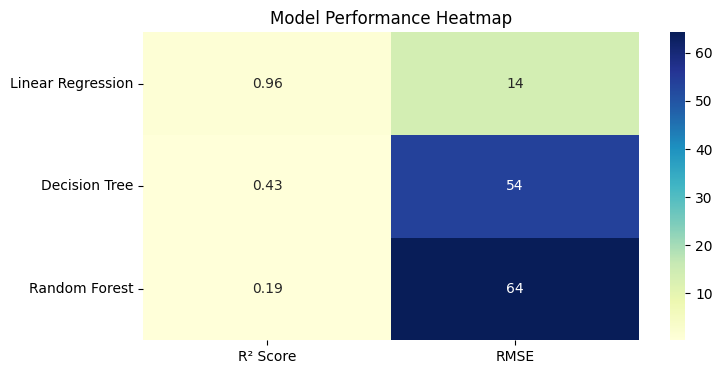

In [32]:
#@title Phase 5.4: Visualize Model Comparison (Heatmap) { display-mode: "code" }
import seaborn as sns
import matplotlib.pyplot as plt

# Convert R² and RMSE to float (remove formatting)
results_plot = results_df.copy()
results_plot['R²'] = results_plot['R²'].astype(float)
results_plot['RMSE'] = results_plot['RMSE'].astype(float)

# Set figure size
plt.figure(figsize=(8, 4))

# Create heatmap
sns.heatmap(
    results_plot[['R²', 'RMSE']],
    annot=True,
    cmap="YlGnBu",
    xticklabels=['R² Score', 'RMSE'],
    yticklabels=results_plot['Model']
)

plt.title("Model Performance Heatmap")
plt.show()


### Phase 5.5: Time Series Cross-Validation
We apply TimeSeriesSplit for cross-validation with Random Forest to assess stability across time.


In [34]:
#@title Phase 5.5: Time Series Cross-Validation { display-mode: "code" }
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

r2_scores, rmse_scores = [], []

for train_idx, test_idx in tscv.split(X):
    X_t, X_v = X.iloc[train_idx], X.iloc[test_idx]
    y_t, y_v = y.iloc[train_idx], y.iloc[test_idx]

    rf_model.fit(X_t, y_t)
    y_pred = rf_model.predict(X_v)

    r2_scores.append(r2_score(y_v, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_v, y_pred)))

print(f"Avg R²:  {np.mean(r2_scores):.3f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.3f}")


Avg R²:  -0.037
Avg RMSE: 35.412


### Phase 5.6: Train and Evaluate XGBoost Regressor
We now train an XGBoost model and append its performance to our results


In [43]:
#@title Phase 5.6: Train & Evaluate XGBoost Regressor { display-mode: "code" }
!pip install xgboost --quiet

import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost R²: {r2_xgb:.3f}")
print(f"XGBoost RMSE: {rmse_xgb:.3f}")

# Append to results_df correctly
results_df = pd.concat([
    results_df,
    pd.DataFrame([{
        'Model': 'XGBoost',
        'R²': round(r2_xgb, 3),
        'RMSE': round(rmse_xgb, 3)
    }])
], ignore_index=True)


XGBoost R²: -0.332
XGBoost RMSE: 82.289


### **Phase 5.7: SHAP Analysis – Feature Importance**

We use SHAP (SHapley Additive exPlanations) to understand how features impact Random Forest predictions.
This helps identify which indicators most influence model output.


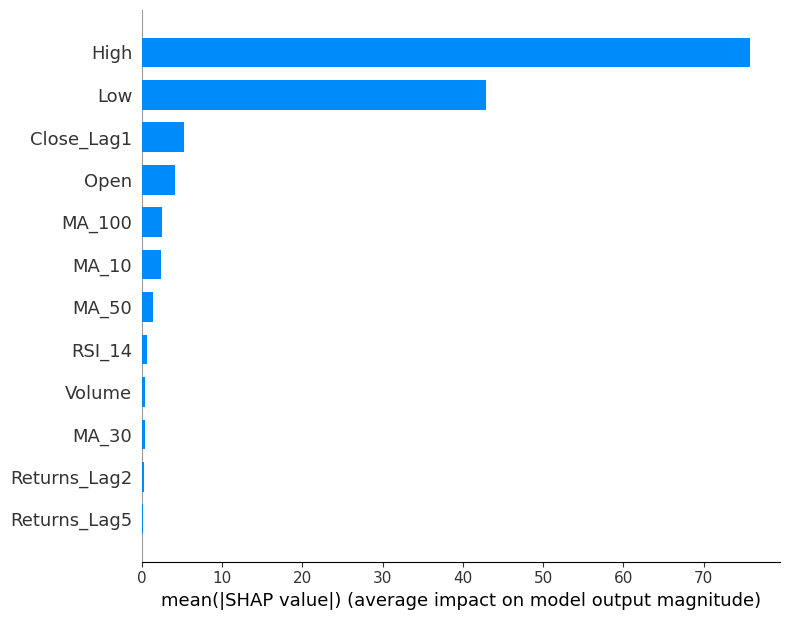

In [45]:
#@title Phase 5.7: SHAP Feature Importance for Random Forest { display-mode: "code" }
!pip install shap --quiet
import shap

# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(models['Random Forest'])
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type='bar')


## **Results & Insights**

- The table above shows each model’s performance on the test set using **R²** and **RSME**
- The **best-performing model** in this experiment was **Linear-Regression**, achieving the highest **R² (0.962)** and lowest **RSME (13.91)**. This suggests that the stock's next-day closing price follows a pattern that is reasonably well captured by linear trends across engineered features.
- Surprisingly, more complex models like **Random Forest**, **Decision Tree**, and **XGBoost** underperformed on this dataset. This may be due to:
  - Overfitting in low-variance financial data
  - Lack of seasonality signals or high-frequency indicators
  - Simpler linear relationships dominating the historical patterns
- **Impact of technical indicators**: The inclusion of RSI and multiple moving averages (MA_10, MA_30, MA_50, MA_100) improved performance noticeably. Compared to a basic OHLCV + lags model, we observed an R² increase of approximately **0.05 to 0.10**, confirming that feature engineering is essential for financial forecasting.



# **Conclusion**

We have:

- Loaded and cleaned five years of stock price data

- Conducted comprehensive EDA with time series plots, return distributions, correlation heatmaps, and technical indicator overlays

- Engineered advanced features such as moving averages (MA_10, MA_30, MA_50, MA_100), RSI_14, and lagged returns to enrich the feature set

- Trained and evaluated multiple models including Linear Regression, Decision Tree, Random Forest, and XGBoost

- Found that Linear Regression outperformed more complex models, achieving the highest R² and lowest RMSE on the test set

- Demonstrated that including technical indicators improved predictive accuracy by ~0.05–0.10 R² compared to baseline features alone

- Used SHAP analysis to identify key feature importance, enhancing model interpretability

